In [1]:
import pandas as pd
import numpy as np

# misc
import datetime as dt
from pprint import pprint
from itertools import chain

# reddit crawler
import praw

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud


In [2]:
nltk.download('vader_lexicon') # get lexicons data
nltk.download('punkt') # for tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ujjwal\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ujjwal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ujjwal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
r = praw.Reddit(
    client_id="zw8uC_emsN_GTyOai4v6OQ",
    client_secret="XJf-l9V2TNGaF9fn6486C0OOEpRplA",
    user_agent="ua"
)

In [4]:
# -------------- Main Code ----------------#
subreddit = r.subreddit('pharmacy')

news = [*subreddit.top(limit=None)] # top posts all time

print(len(news))


998


In [5]:
news0 = news[0]

# pprint(vars(news0)) 
print(news0.title) # headline
print(news0.score) # upvotes
print(news0.created) # UNIX timestamps 
print(dt.datetime.fromtimestamp(news0.created)) # date and time
print(news0.num_comments) # no. of comments
print(news0.upvote_ratio) # upvote / total votes
print(news0.total_awards_received) # no. of awards given

My DM at CVS just gave us 20 extra hours for the next 4 months, plus a pay increase on top of PPE supplies and assured us that metrics don’t matter and that our safety as employees and human beings comes first
2098
1585757650.0
2020-04-01 12:14:10
89
0.98
3


In [6]:
# create lists of the information from each news
title = [news.title for news in news]

In [7]:
news = pd.DataFrame({
    "title": title,
})
news.head()

,title
0,My DM at CVS just gave us 20 extra hours for t...
1,The Reality (Ugly Truth) of CVS Pharmacy
2,Finally finished my pharmacy. Opening Day is t...
3,The Flu Clinic was 🔥 today
4,CVS employees take COVID-19 safety into their ...


In [8]:
sid = SentimentIntensityAnalyzer()

pos_text = "Vader is awesome"
cap_pos_text = "Vader is AWESOME!" # captilization and ! increases the effect
neg_text = "Vader is bad"

print(sid.polarity_scores(pos_text))
print(sid.polarity_scores(cap_pos_text))
print(sid.polarity_scores(neg_text))

{'neg': 0.0, 'neu': 0.328, 'pos': 0.672, 'compound': 0.6249}
{'neg': 0.0, 'neu': 0.281, 'pos': 0.719, 'compound': 0.729}
{'neg': 0.636, 'neu': 0.364, 'pos': 0.0, 'compound': -0.5423}


In [9]:
res = [*news['title'].apply(sid.polarity_scores)]
pprint(res[:3])

[{'compound': 0.7964, 'neg': 0.031, 'neu': 0.741, 'pos': 0.229},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.9078, 'neg': 0.0, 'neu': 0.727, 'pos': 0.273}]


In [10]:
sentiment_df = pd.DataFrame.from_records(res)
news = pd.concat([news, sentiment_df], axis=1, join='inner')
news.head()

,title,neg,neu,pos,compound
0,My DM at CVS just gave us 20 extra hours for t...,0.031,0.741,0.229,0.7964
1,The Reality (Ugly Truth) of CVS Pharmacy,0.000,1.000,0.000,0.0000
2,Finally finished my pharmacy. Opening Day is t...,0.000,0.727,0.273,0.9078
3,The Flu Clinic was 🔥 today,0.394,0.606,0.000,-0.3818
4,CVS employees take COVID-19 safety into their ...,0.073,0.809,0.118,0.2960


In [11]:
THRESHOLD = 0.2

conditions = [
    (news['compound'] <= -THRESHOLD),
    (news['compound'] > -THRESHOLD) & (news['compound'] < THRESHOLD),
    (news['compound'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]
news['label'] = np.select(conditions, values)

news.head()

,title,neg,neu,pos,compound,label
0,My DM at CVS just gave us 20 extra hours for t...,0.031,0.741,0.229,0.7964,pos
1,The Reality (Ugly Truth) of CVS Pharmacy,0.000,1.000,0.000,0.0000,neu
2,Finally finished my pharmacy. Opening Day is t...,0.000,0.727,0.273,0.9078,pos
3,The Flu Clinic was 🔥 today,0.394,0.606,0.000,-0.3818,neg
4,CVS employees take COVID-19 safety into their ...,0.073,0.809,0.118,0.2960,pos


In [12]:
sentence0 = news.title.iloc[0]
print(sentence0)
words0 = news.title.iloc[0].split()
print(words0)

pos_list, neg_list, neu_list = [], [], []

for word in words0:
  if (sid.polarity_scores(word)['compound']) >= THRESHOLD:
    pos_list.append(word)
  elif (sid.polarity_scores(word)['compound']) <= -THRESHOLD:
    neg_list.append(word)
  else:
    neu_list.append(word)                

print('\nPositive:',pos_list)        
print('Neutral:',neu_list)    
print('Negative:',neg_list) 
score = sid.polarity_scores(sentence0)

print(f"\nThis sentence is {round(score['neg'] * 100, 2)}% negative")
print(f"This sentence is {round(score['neu'] * 100, 2)}% neutral")
print(f"This sentence is {round(score['pos'] * 100, 2)}% positive")
print(f"The compound value : {score['compound']} <= {-THRESHOLD}")
print(f"\nThis sentence is NEGATIVE")

# source https://stackoverflow.com/a/51515048/11386747

My DM at CVS just gave us 20 extra hours for the next 4 months, plus a pay increase on top of PPE supplies and assured us that metrics don’t matter and that our safety as employees and human beings comes first
['My', 'DM', 'at', 'CVS', 'just', 'gave', 'us', '20', 'extra', 'hours', 'for', 'the', 'next', '4', 'months,', 'plus', 'a', 'pay', 'increase', 'on', 'top', 'of', 'PPE', 'supplies', 'and', 'assured', 'us', 'that', 'metrics', 'don’t', 'matter', 'and', 'that', 'our', 'safety', 'as', 'employees', 'and', 'human', 'beings', 'comes', 'first']

Positive: ['increase', 'top', 'assured', 'safety']
Neutral: ['My', 'DM', 'at', 'CVS', 'just', 'gave', 'us', '20', 'extra', 'hours', 'for', 'the', 'next', '4', 'months,', 'plus', 'a', 'pay', 'on', 'of', 'PPE', 'supplies', 'and', 'us', 'that', 'metrics', 'don’t', 'matter', 'and', 'that', 'our', 'as', 'employees', 'and', 'human', 'beings', 'comes', 'first']
Negative: []

This sentence is 3.1% negative
This sentence is 74.1% neutral
This sentence is 22

In [13]:
news.label.value_counts()

neu    491
pos    291
neg    216
Name: label, dtype: int64

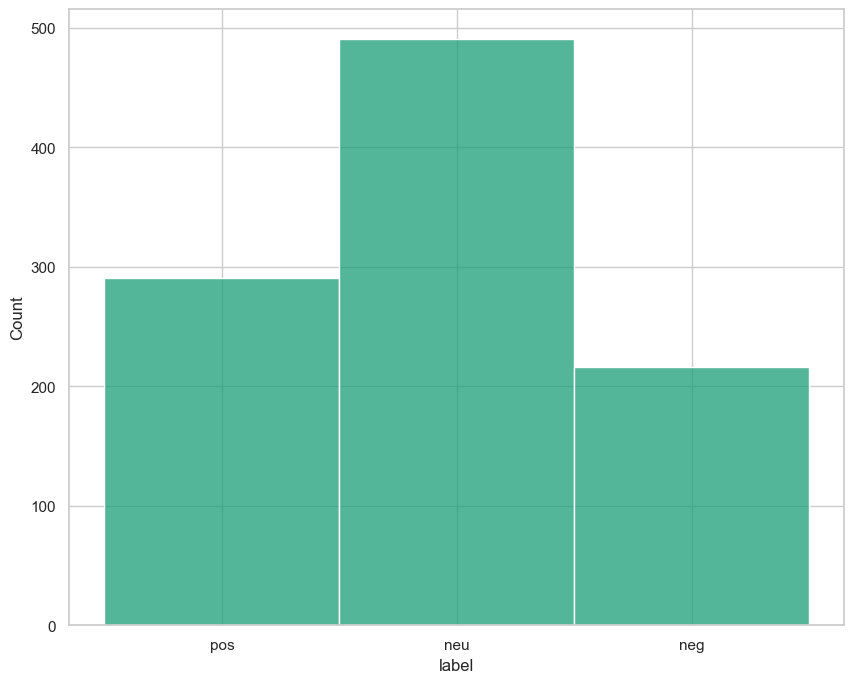

In [14]:
sns.histplot(news.label);

In [15]:
def news_title_output(df, label):
  res = df[df['label'] == label].title.values
  print(f'{"=" * 20}')
  print("\n".join(title for title in res))

# randomly sample
news_sub = news.groupby('label').sample(n = 5, random_state = 7)

print("Positive news")
news_title_output(news_sub, "pos")

print("\nNeutral news")
news_title_output(news_sub, "neu")

print("\nNegative news")
news_title_output(news_sub, "neg")

Positive news
Pharmacists save lives
A special place for those that do this
Would you like some metformin with your burrito? 🌯
Cefiderocol: A Novel Cephalosporin
Can we get these for every pharmacy worker ever please?

Neutral news
Nurse Threw Away Patient Meds
Losartan Potassium and Potassium are NOT the same
I humbly present to you the Vyvanse coffee cup irl
I have all your old drugs beat with this gem.
Here's a little gem of a forgery incident circulated by our College

Negative news
When you get flowers delivered, but no vase?
Got verbally destroyed by MD, was I wrong?
Coming to a crowded store is way more risky than not having a face mask!!! Stop visiting a bunch of stores looking for them, you are far more likely to catch something by wandering around crowded places!
Pharmacy school lied to me
You let a woman die. Please go fuck yourself instead.


In [16]:
text = "Let's see how the NLTK tokenizer works!"

# using word tokenizer
print(nltk.word_tokenize(text))

# using regexp tokenizer
tk = nltk.tokenize.RegexpTokenizer(r'\s+', gaps=True) # split on whitespace
print(tk.tokenize(text))

tk = nltk.tokenize.RegexpTokenizer(r'\w+') # remove punct
print(tk.tokenize(text))

['Let', "'s", 'see', 'how', 'the', 'NLTK', 'tokenizer', 'works', '!']
["Let's", 'see', 'how', 'the', 'NLTK', 'tokenizer', 'works!']
['Let', 's', 'see', 'how', 'the', 'NLTK', 'tokenizer', 'works']


In [17]:
stop_words = stopwords.words('english')
print(len(stop_words))
print(stop_words[:10])

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [18]:
def custom_tokenize(text):
  # remove single quote and dashes
  text = text.replace("'", "").replace("-", "").lower()

  # split on words only
  tk = nltk.tokenize.RegexpTokenizer(r'\w+')
  tokens = tk.tokenize(text)

  # remove stop words
  words = [w for w in tokens if not w in stop_words]
  return words

print(custom_tokenize(text))

['lets', 'see', 'nltk', 'tokenizer', 'works']


In [19]:
def tokens_2_words(df, label):
  # subset titles based on label
  titles = df[df['label'] == label].title
  # apply our custom tokenize function to each title
  tokens = titles.apply(custom_tokenize)
  # join nested lists into a single list
  words = list(chain.from_iterable(tokens))
  return words

pos_words = tokens_2_words(news, 'pos')
neg_words = tokens_2_words(news, 'neg')

In [20]:
pos_freq = nltk.FreqDist(pos_words)
pos_freq.most_common(20)

[('pharmacy', 53),
 ('like', 32),
 ('pharmacist', 25),
 ('pharmacists', 20),
 ('love', 17),
 ('day', 16),
 ('today', 15),
 ('cvs', 14),
 ('one', 14),
 ('retail', 13),
 ('get', 12),
 ('us', 11),
 ('new', 11),
 ('work', 11),
 ('please', 11),
 ('first', 10),
 ('got', 10),
 ('take', 10),
 ('ever', 10),
 ('happy', 10)]

In [21]:
neg_freq = nltk.FreqDist(neg_words)
neg_freq.most_common(20)

[('pharmacy', 39),
 ('pharmacists', 23),
 ('cvs', 19),
 ('pharmacist', 15),
 ('work', 10),
 ('anyone', 9),
 ('walgreens', 9),
 ('patients', 8),
 ('flu', 7),
 ('today', 7),
 ('hate', 7),
 ('im', 7),
 ('patient', 7),
 ('stop', 7),
 ('day', 7),
 ('pharmacies', 6),
 ('getting', 6),
 ('wrong', 6),
 ('time', 6),
 ('one', 6)]

In [22]:
print(type(neg_freq))

<class 'nltk.probability.FreqDist'>


In [23]:
print(neg_freq)

<FreqDist with 932 samples and 1453 outcomes>


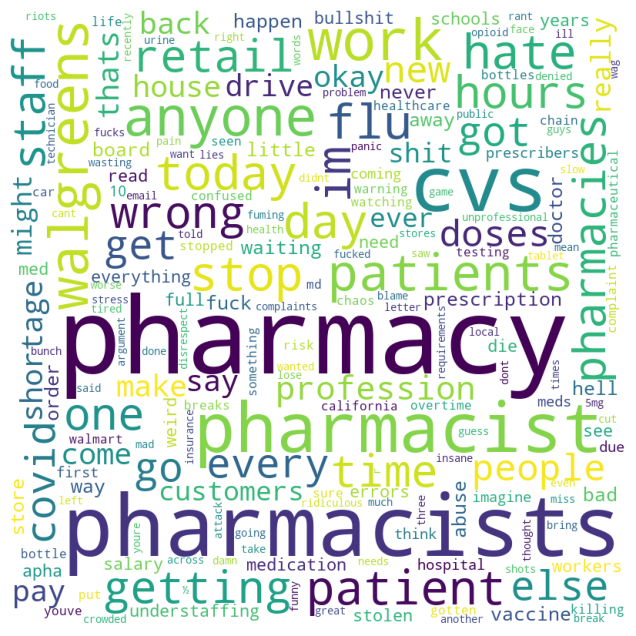

In [24]:
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(neg_freq)
# Plot the WordCloud image
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

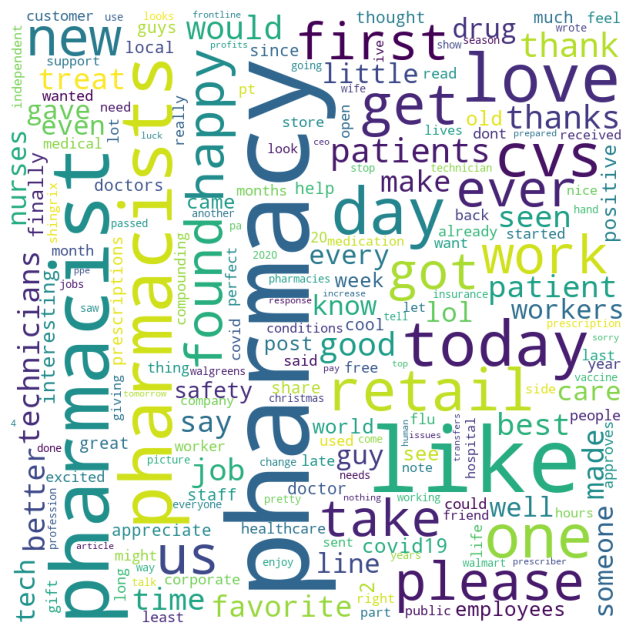

In [25]:
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(pos_freq)
# Plot the WordCloud image
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()